In this notebook, we test 2 capabilities of LLMs:

1. **Recognition**: Can an LLM recognize that a state-action trajectory is different than what is expected?
2. **Rectification**: Can an LLM update simulation code to match the expected state-action trajectory?

In [2]:
# Import standard packages
import os
import sys
import traceback
import multiprocessing
import numpy as np

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Recognition

We will test whether an LLM can recognize that a state-action trajectory is different than what is expected and determine the source of the difference. We will use the Mountain Car environment from Gymnasium. The "external" environment will have a different gravity level than the "internal" environment. The LLM will see both state-action trajectories and determine what the source of the difference is. This is clearly a difficult problem computationally since the source of the difference is not directly observable and there can be many different sources of the difference.

We will try to start with the easiest possible test: Match the action sequence of the external environment to the internal environment. Though we call this task easy, it is still computationally difficult because there can be many possible reasons for the difference in state trajectories.

### Setup LLM

In [67]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.2",
    temperature=0.5,
    n_gpu_layers=-1,
    n_threads=multiprocessing.cpu_count() - 1,
    verbose=False,
    seed=-1 # Random behavior so will not output the same thing always
)
# We need a random seed for exploration purposes. So, this is an algorithmic choice.

# resp = llm.invoke("Write a Python program that generates the first 10 numbers in the Fibonacci sequence. Include only the code. Any comments or explanations should be removed.")
# print(resp.content)

LLMs tend to code better when told to output entire code snippets as opposed to individual lines. This is because the model can better understand the context of the code. Perhaps we can use chain-of-thought with entire code snippets as one part of the chain and then utilize standard git tools to determine changes.

Mountain Car has the following spec:

* Observation space: (Positive, Velocity)
* Action space: (0 [left], 1 [stay], 2 [right])

In [58]:
import gymnasium as gym
# Generate a state-action trajectory from mountain car with gravity 0.0025 (normal)

env_normal = gym.make("MountainCar-v0")
env_normal.unwrapped.gravity = 0.0025
seed = 0

observation, info = env_normal.reset(seed=seed) # set the seed so they start in the same place

episode_over = False
states_normal = [env_normal.unwrapped.state]
actions_normal = []

action_space = [0,1,2]

np.random.seed(seed) # reset seed so same actions
while not episode_over:
    action = np.random.choice(action_space)  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env_normal.step(action)
    states_normal.append(observation)
    actions_normal.append(action)

    episode_over = terminated or truncated

env_normal.close()

# Generate a state-action trajectory from mountain car with gravity 0.005 (double gravity)
env_double = gym.make("MountainCar-v0")
env_double.unwrapped.gravity = 0.005

observation, info = env_double.reset(seed=seed)

episode_over = False
states_double = [env_double.unwrapped.state]
actions_double = []

np.random.seed(seed) # reset seed so same actions
while not episode_over:
    action = np.random.choice(action_space)  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env_double.step(action)
    states_double.append(observation)
    actions_double.append(action)

    episode_over = terminated or truncated

env_double.close()

states_normal = np.array(states_normal)
actions_normal = np.array(actions_normal)

states_double = np.array(states_double)
actions_double = np.array(actions_double)

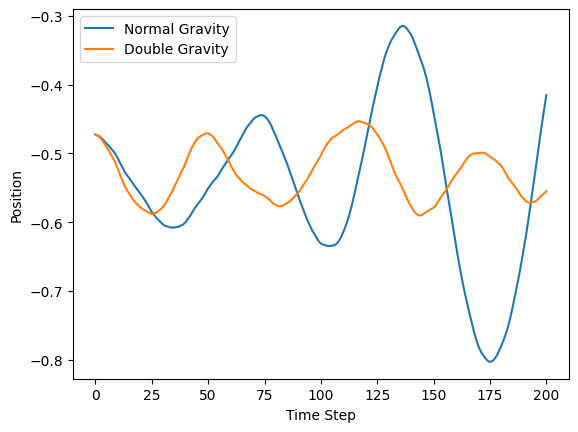

In [59]:
import matplotlib.pyplot as plt

plt.plot(range(states_normal.shape[0]), states_normal[:, 0], label="Normal Gravity")
plt.plot(range(states_double.shape[0]), states_double[:, 0], label="Double Gravity")
plt.xlabel("Time Step")
plt.ylabel("Position")
plt.legend()
plt.show()

In [69]:
description = """The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. There are two versions of the mountain car domain in gymnasium: one with discrete actions and one with continuous. This version is the one with continuous actions. The dynamics of the car are determined by the following equations: 
velocity_{t+1} = velocity_t + (action - 1) * force - cos(3 * position_t) * gravity
position_{t+1} = position_t + velocity_{t+1}
"""

prompt = f"""The following are two trajectories of the mountain car environment with something changed between them. The trajectories have the same action sequence. The first column is the position of the car and the second column is the velocity of the car.
Trajectory 1:\n{states_normal[:10]}\nTrajectory 2:\n{states_double[:10]}

What is the fundamental difference between the environments that generates these two trajectories?"""

print(description + prompt)

The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. There are two versions of the mountain car domain in gymnasium: one with discrete actions and one with continuous. This version is the one with continuous actions. The dynamics of the car are determined by the following equations: 
velocity_{t+1} = velocity_t + (action - 1) * force - cos(3 * position_t) * gravity
position_{t+1} = position_t + velocity_{t+1}
The following are two trajectories of the mountain car environment with something changed between them. The trajectories have the same action sequence. The first column is the position of the car and the second column is the velocity of the car.
Trajectory 1:
[[-0.47260766  0.        ]
 [-0.47398

In [70]:
resp = llm.invoke(prompt)
print(resp.content)

The fundamental difference between the environments that generate these two trajectories is likely due to a change in the gravity or acceleration of the car.

In Trajectory 1, the velocity decreases gradually and uniformly over time, indicating a constant gravitational force acting on the car. This suggests that the environment has a uniform gravity, where the acceleration due to gravity (g) is the same at all points in space.

In contrast, Trajectory 2 shows a more rapid decrease in velocity, indicating a stronger gravitational force or a greater acceleration. The changes in velocity are also less predictable and more irregular than in Trajectory 1, suggesting that the environment has a non-uniform gravity or other forces acting on the car.

Another possibility is that the change between the environments could be due to a different friction model or a different type of terrain. However, without further information about the specific physics engine or simulation used to generate these 